# Functions

## Imports & logging

In [1]:
import json
import logging

import geopandas as gpd
import numpy as np
import pandas as pd
import s3fs as s3
import xarray as xr

In [2]:
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

## Datacube access & sampling

In [3]:
def get_datacube_instances(points):
    """Identifies the ITS_LIVE Zarr datacubes corresponding to sampling points.

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        GeoDataFrame containing points along a glacier centreline.

    Returns
    -------
    datacubes : list of str
        List unique datacube URLs.
    points : geopandas.GeoDataFrame
        points with corresponding datacube URL appended.

    See also
    --------
    sample_datacubes
    """

    # Reads ITS_LIVE Zarr datacube catalog as GeoDataFrame
    s3fs = s3.S3FileSystem(anon=True)
    catalog_url = "s3://its-live-data/datacubes/catalog_v02.json"
    with s3fs.open(catalog_url, "r") as datacube_catalog:
        datacube_catalog = json.load(datacube_catalog)
        datacube_catalog = gpd.GeoDataFrame.from_features(datacube_catalog, crs=4326)

    # Intersects points with datacube outlines
    points = (
        points.to_crs(4326)
        .overlay(datacube_catalog[["geometry", "zarr_url"]], how="intersection")
        .set_index(["glacier", "cd"])
        .to_crs(3413)
    )

    # Amends URLs
    points["zarr_url"] = (
        points["zarr_url"].str.replace("http:", "s3:").str.replace(".s3.amazonaws.com", "")
    )

    # Creates list of unique datacubes (as their URLs)
    datacubes = points["zarr_url"].unique().tolist()
    logger.info(f"Number of unique datacubes: {len(datacubes)}")

    return datacubes, points

In [4]:
def sample_datacubes(datacubes, points, spatial_averaging=True):
    """Samples ITS_LIVE Zarr datacube at points.

    Parameters
    ----------
    datacubes : list of str
        List unique datacube URLs.
    points : geopandas.GeoDataFrame
        GeoDataFrame containing points along a glacier centreline.
    spatial_averaging : bool
        Flag to sample in a 3x3 window around each point [default=True].

    Returns
    -------
    datasets : list of xarray.Dataset
        Sampled datasets with the dimensions:
            - mid_date  ...
            - glacier   ...
            - cd        binned distance along centreline
            - k         int (0-8) each point in the 3x3 kernel

    See also
    --------
    get_datacube_instances
    """

    # Creates storage needed for spatial averaging, if necessary
    if spatial_averaging:
        points["windows"] = pd.Series(dtype=object)

    # Creates storage for sampled datasets
    datasets = []

    for dc_url in datacubes:
        # Gets index of points within current the datacube
        z_idx = points["zarr_url"] == dc_url

        with xr.open_dataset(dc_url, engine="zarr", storage_options={"anon": True}) as dc:
            if not spatial_averaging:
                # Gets point x and y coords
                point_x = points.loc[z_idx, "x"].to_xarray()
                point_y = points.loc[z_idx, "y"].to_xarray()
                mask = ~np.isnan(point_x)

                # Queries datacube at point
                dc = dc.sel(x=point_x, y=point_y, method="nearest").sortby("mid_date")

            else:
                # Creates additional points for 3x3 kernal about each index
                diffs_x = np.abs(points.loc[z_idx, "x"].values - dc["x"].values[:, np.newaxis])
                diffs_y = np.abs(points.loc[z_idx, "y"].values - dc["y"].values[:, np.newaxis])
                x_idx = diffs_x.argmin(axis=0)
                y_idx = diffs_y.argmin(axis=0)
                windows = []
                for x, y in list(zip(x_idx, y_idx)):
                    window = []
                    for y_ in [y + 1, y, y - 1]:
                        for x_ in [x - 1, x, x + 1]:
                            window.append((x_, y_))
                    windows.append(window)

                # Appends window indicies to points GeoDataFrame
                points.loc[z_idx, "windows"] = pd.Series(
                    windows, index=points.loc[z_idx].index
                )

                # Unpacks list of windows
                points = (
                    points.loc[z_idx, "windows"]
                    .apply(pd.Series)
                    .reset_index()
                    .melt(["glacier", "cd"])
                    .sort_values(by=["glacier", "cd"])
                    .rename(columns={"variable": "k", "value": "idx"})
                    .set_index(["glacier", "cd", "k"])
                )

                # Unpacks each window's tuple
                points = (
                    points["idx"].apply(pd.Series).rename(columns={0: "x_idx", 1: "y_idx"})
                )

                # Removes invalid indicies caused when points cross a datacube boundary
                invalid = (
                    (points["y_idx"] >= len(dc["y"]))
                    | (points["y_idx"] < 0)
                    | (points["x_idx"] >= len(dc["x"]))
                    | (points["x_idx"] < 0)
                )
                points = points[~invalid]

                # Gets point x and y coords
                point_x = points["x_idx"].to_xarray()
                point_y = points["y_idx"].to_xarray()
                mask = ~np.isnan(point_x)

                # Handles NaN values created when dealing with centrelines of differing length
                point_x = xr.where(mask, point_x, 0).astype(int)
                point_y = xr.where(mask, point_y, 0).astype(int)

                # Queries datacube at point
                dc = dc.isel(x=point_x, y=point_y).sortby("mid_date")

            # Masks NaN values
            dc["x"] = xr.where(mask, dc["x"], np.nan)
            dc["y"] = xr.where(mask, dc["y"], np.nan)
            dc["mask"] = mask

            logger.info(f"Datacube dimensions: {dc.dims}")
            datasets.append(dc.chunk(chunks={"cd": 15, "glacier": 1}))

    logger.info(f"Number of datacubes loaded: {len(datasets)}")

    return datasets

## Processing

### Error weighting & uncertainty

In [5]:
def error_weighted_average(values, error, resample_frequency="AS"):
    """Calculates error weighted average.

    Parameters
    ----------
    values : xarray.DataArray
        Values to average.
    error : xarray.DataArray
        Error associated with each value.
    resample_frequency : str
        Resampling frequency.

    Returns
    -------
    weighted_average : xarray.DataArray
        Error weighted average, resampled to the specified frequency.
    combined_uncertainty : xarray.DataArray
        Associated uncertainty.
    std : xarray.DataArray
        Associated standard deviations.

    See also
    --------
    get_annual_averages
    get_seasonal_averages
    get_time_series
    v_uncertainty
    """

    empty = np.zeros(values.shape)
    empty[:] = np.nan

    error_masked = xr.where(np.isnan(values), empty, error)
    weights = 1 / (error_masked**2)

    top = (weights * values).resample(mid_date=resample_frequency).sum()
    bottom = weights.resample(mid_date=resample_frequency).sum()
    weighted_average = top / bottom

    combined_uncertainty = np.sqrt(1 / (weights.resample(mid_date=resample_frequency).sum()))
    std = values.resample(mid_date=resample_frequency).std()

    return (
        weighted_average.rename("v"),
        combined_uncertainty.rename("v_error"),
        std.rename("std"),
    )

In [6]:
def v_uncertainty(vx, vy, vx_error=0, vy_error=0):
    """Calculates velocity and associated uncertainty from vx and vy components.

    Parameters
    ----------
    vx : xarray.DataArray
        vx velocity component.
    vy : xarray.DataArray
        vy velocity component.
    vx_error : xarray.DataArray
        Error associated with vx velocity component.
    vy_error : xarray.DataArray
        Error associated with vy velocity component.

    Returns
    -------
    v : xarray.DataArray
        Resultant velocity, calculated from vx and vy components.
    v_error : xarray.DataArray
        Associated uncertainty.

    Notes
    -----
    v = sqrt(vx^2 + vy^2)

    See also
    --------
    error_weighted_average
    get_annual_averages
    get_seasonal_averages
    get_time_series
    """

    def pow_err(q, x, dx, n):
        """Returns uncertainty in q (dq), where q = x^n and x has uncertainty dx
        dq / |q| = |n|* dx / |x|
        """
        return np.abs(q) * np.abs(n) * (dx / np.abs(x))

    vx2_error = pow_err(vx**2, vx, vx_error, 2)  # error in vx^2
    vy2_error = pow_err(vy**2, vy, vy_error, 2)  # error in vy^2

    sq_sum = vx**2 + vy**2
    sq_sum_error = np.hypot(vx2_error, vy2_error)  # error in vx^2 + vy^2

    v = np.sqrt(sq_sum)  # resultant velocity
    v_error = pow_err(v, sq_sum, sq_sum_error, 0.5)  # error in resultant velocity

    return v, v_error

### Annual averages

In [7]:
def get_annual_averages(datasets, date_dt_min, date_dt_max):
    """Calculates average annual velocities.

    Parameters
    ----------
    datasets : list of xarray.DataArray
        Sampled IT_LIVE data.
    date_dt_min : str
        pandas timedelta string specifying minimum date_dt.
    date_dt_max : str
        pandas timedelta string specifying minimum date_dt.

    Returns
    -------
    v_annual : pandas.DataFrame
        DataFrame of average annual velocities and their associated error.
    v_all : pandas.DataFrame
        DataFrame of spatially averaged velocities at *all* timesteps in the original xarray.Dataset (useful
        for plotting standard deviations with seaborn using .groupby(['glacier','cd','year]))

    Notes
    -----
    Filters sampled velocity data to only include that derived from image pairs with a
    separation time (date_dt) between date_dt_min and date_dt_max.

    See also
    --------
    error_weighted_average
    get_seasonal_averages
    get_time_series
    v_uncertainty
    """

    annual_v = []
    annual_v_error = []

    for ds in datasets:
        # Filter date_dt between date_dt_min and date_dt_max
        date_dt_idx = (ds["date_dt"] >= pd.Timedelta(date_dt_min)) & (
            ds["date_dt"] <= pd.Timedelta(date_dt_max)
        )

        if "k" not in list(ds.dims):
            # No spatial averaging
            v, v_error, _ = error_weighted_average(
                ds["v"][date_dt_idx, :, :], ds["v_error"][date_dt_idx, :, :]
            )
            annual_v.append(v)
            annual_v_error.append(v_error)

        else:
            # Calculates average velocity within each kernal from vx and vy components
            average_vx = ds["vx"][date_dt_idx.compute(), :, :, :].mean(dim="k", skipna=True)
            average_vy = ds["vy"][date_dt_idx.compute(), :, :, :].mean(dim="k", skipna=True)
            average_v, average_v_error = v_uncertainty(
                average_vx,
                average_vy,
                ds["vx_error"][date_dt_idx.compute()],
                ds["vy_error"][date_dt_idx.compute()],
            )

            v, v_error, _ = error_weighted_average(average_v, average_v_error)

            output_shape = dict(zip(v.dims, v.shape))
            valid_idx = np.repeat(
                (ds["mask"].mean(dim="k").values == 1)[np.newaxis, :, :],
                repeats=output_shape["mid_date"],
                axis=0,
            )

            v = xr.where(valid_idx, v, np.nan)
            v_error = xr.where(valid_idx, v_error, np.nan)
            annual_v.append(v)
            annual_v_error.append(v_error)

    # Merge annual datasets
    v = xr.merge(annual_v)["v"]
    v_error = xr.merge(annual_v_error)["v_error"]

    # Convert to DataFrame for better control over plotting
    v_error_annual = v_error.to_dataframe(
        name="v_error", dim_order=["glacier", "cd", "mid_date"]
    )
    v_annual = v.to_dataframe(name="v", dim_order=["glacier", "cd", "mid_date"])
    v_annual = v_annual.merge(v_error_annual, left_index=True, right_index=True)

    v_annual["year"] = v_annual.index.get_level_values(level=2).year
    v_annual["pcnt"] = (
        v_annual["v"]
        / v_annual.loc[
            v_annual.groupby(["glacier", "cd"])["year"].transform("idxmin"), "v"
        ].values
    ) * 100
    v_annual.reset_index(inplace=True)

    v_all = average_v.to_dataframe(name="v", dim_order=["glacier", "cd", "mid_date"])
    v_all["year"] = v_all.index.get_level_values(level=2).year
    v_all.reset_index(inplace=True)

    return v_annual, v_all

### Seasonal averages

In [17]:
def get_seasonal_averages(
    datasets, start_d, stop_d, date_dt_max="30D", resample_frequency="Q-FEB"
):
    """Calculates average seasonal velocities.

    Parameters
    ----------
    datasets : list of xarray.Dataset
        Sampled IT_LIVE data.
    start_d : str
        pandas timedelta string for filtering on mid_date.
    stop_d : str
        pandas timedelta string for filtering on mid_date.
    date_dt_max : str
        pandas timedelta string specifying maximum date_dt [default=30].
    resample_frequency : str
        String specifying resampling frequency [default=Q-FEB].

    Returns
    -------
    v_seasonal : pandas.DataFrame
        DataFrame of average seasonal velocities with the columns
            - glacier, cd, mid_date [with frequency = resample_frequency), v, season, year

    See also
    --------
    error_weighted_average
    get_seasonal_averages
    get_time_series
    v_uncertainty
    """

    seasonal_v = []

    for ds in datasets:
        # Date range and date_dt filter
        d_idx = ds["mid_date"].to_pandas().between(start_d, stop_d)
        date_dt_idx = ds["date_dt"] <= pd.Timedelta(date_dt_max)
        mid_date_idx = date_dt_idx & d_idx


        if "k" not in list(ds.dims):
            v_average = ds["v"][mid_date_idx, :, :]
            v, _, _ = error_weighted_average(
                ds["v"][mid_date_idx, :, :], ds["v_error"][mid_date_idx, :, :]
            )
            seasonal_v.append(v)
        else:
            average_vx = ds["vx"][mid_date_idx, :, :, :].mean(dim="k", skipna=True)
            average_vx = ds["vy"][mid_date_idx, :, :, :].mean(dim="k", skipna=True)
            average_v, average_v_error = v_uncertainty(
                average_vx,
                average_vx,
                ds["vx_error"][mid_date_idx],
                ds["vy_error"][mid_date_idx],
            )
            v, _, _ = error_weighted_average(
                average_v, average_v_error, resample_frequency=resample_frequency
            )

            output_shape = dict(zip(v.dims, v.shape))
            valid_idx = np.repeat(
                (ds["mask"].mean(dim="k").values == 1)[np.newaxis, :, :],
                repeats=output_shape["mid_date"],
                axis=0,
            )

            v = xr.where(valid_idx, v, np.nan)

            seasonal_v.append(v)

    seasons = {1: "DJF", 2: "MAM", 3: "JJA", 4: "SON"}
    v_seasonal = xr.merge(seasonal_v)["v"]
    v_seasonal = v_seasonal.to_dataframe(dim_order=["glacier", "cd", "mid_date"])
    v_seasonal.reset_index(inplace=True)
    v_seasonal["season"] = (v_seasonal["mid_date"].dt.month % 12 // 3 + 1).map(seasons)
    v_seasonal["year"] = v_seasonal["mid_date"].dt.year

    return v_seasonal

### Time series

In [22]:
def get_time_series(datasets, start_d, stop_d, distances, date_dt_max="30D"):
    """Gets velocity time series at points and resamples them to regular frequencies.

    Parameters
    ----------
    datasets : list of xarray.Dataset
        Sampled IT_LIVE data.
    start_d : str
        pandas timedelta string for filtering on mid_date.
    stop_d : str
        pandas timedelta string for filtering on mid_date.
    distances : list
        list of distances along centreline (cd) to include.
    date_dt_max : str
        pandas timedelta string specifying maximum date_dt [default=30].


    Returns
    -------
    v_time_series : pandas.DataFrame
        DataFrame of velocities that meet date, date_dt, and cd filter requirements.
            - glacier, cd, mid_date [with frequency = resample_frequency), v, season, year

    See also
    --------
    error_weighted_average
    get_seasonal_averages
    get_time_series
    v_uncertainty
    """

    filtered = []

    for ds in datasets:

        d_idx = ds["mid_date"].to_pandas().between(start_d, stop_d)

        date_dt_idx = ds["date_dt"] <= pd.Timedelta(date_dt_max)

        mid_date_idx = date_dt_idx & d_idx

        cd_idx = ds["cd"].isin(distances)


        if "k" not in list(ds.dims):  # then spatial averaging
            average_v, average_v_error = v_uncertainty(
                ds["vx"][mid_date_idx, :, cd_idx],
                ds["vy"][mid_date_idx, :, cd_idx],
                ds["vx_error"][mid_date_idx],
                ds["vy_error"][mid_date_idx],
            )
        else:
            average_vx = ds["vx"][mid_date_idx, :, cd_idx, :].mean(dim="k", skipna=True)

            average_vy = ds["vy"][mid_date_idx, :, cd_idx, :].mean(dim="k", skipna=True)

            average_v, average_v_error = v_uncertainty(
                average_vx,
                average_vy,
                ds["vx_error"][mid_date_idx],
                ds["vy_error"][mid_date_idx],
            )

        filtered.append(
            xr.merge(
                [
                    average_v.rename("v"),
                    average_v_error.rename("v_error"),
                    ds[
                        [
                            "acquisition_date_img1",
                            "acquisition_date_img2",
                            "date_dt",
                            "satellite_img1",
                            "mission_img1",
                        ]
                    ].sel(mid_date=mid_date_idx),
                ]
            )
        )


    v_time_series = xr.merge(filtered)

    v_time_series = v_time_series.to_dataframe()


    v_time_series = v_time_series[~v_time_series["v"].isna()]


    # 28-day rolling median

    v_time_series = v_time_series.merge(
        v_time_series.reset_index(level=[1, 2])
        .groupby(["glacier", "cd"])["v"]
        .rolling("28D")
        .median()
        .rename("smoothed_v")
        .reset_index(),
        left_on=["mid_date", "glacier", "cd"],
        right_on=["mid_date", "glacier", "cd"],
    )


    # calculate intermediate steps for error-weighted averages

    v_time_series["v_over_sigma2"] = v_time_series["v"] / (v_time_series["v_error"] ** 2)

    v_time_series["one_over_sigma2"] = 1 / (v_time_series["v_error"] ** 2)


    return v_time_series

# Analysis

## Imports & set-up

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dask.distributed import Client
from scipy.stats import linregress

In [9]:
# Defines plot settings
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

In [10]:
dask_client = Client()
logger.info(f"Dask dashboard: {dask_client.dashboard_link}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory 'C:\\Users\\olive\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-li1glcml', purging
INFO:distributed.diskutils:Found stale lock file and directory 'C:\\Users\\olive\\AppData\\Local\\Temp\\dask-scratch-space\\worker-ahkqv0z0', purging
INFO:distributed.diskutils:Found stale lock file and directory 'C:\\Users\\olive\\AppData\\Local\\Temp\\dask-scratch-space\\worker-jwtrxblw', purging
INFO:distributed.diskutils:Found stale lock file and directory 'C:\\Users\\olive\\AppData\\Local\\Temp\\dask-scratch-space\\worker-mfniq75h', purging
INFO:distributed.diskutils:Found stale lock file and directory 'C:\\Users\\olive\\AppData\\Local\\Temp\\dask-scratch-space\\worker-uqcx35w8', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.

## Read points

In [28]:
# Reads sampling points
points_path = "samplePoints_feather"
points = gpd.read_feather(points_path)

selection = points["glacier"].unique().tolist()

In [42]:
import pprint

print(points.to_string())

                 glacier     cd              x             y                                          xy                          geometry     relDist   cd_raw
2     IsortuarsuupSermia      0 -250669.485841 -2.871731e+06    [-250669.48584135523, -2871730.73362698]  POINT (-250669.486 -2871730.734)  517.769562    498.0
3     IsortuarsuupSermia    250 -250425.912979 -2.871680e+06   [-250425.91297932292, -2871679.929666061]  POINT (-250425.913 -2871679.930)  517.769562    747.0
4     IsortuarsuupSermia    500 -250179.554405 -2.871644e+06   [-250179.55440470992, -2871644.167937488]  POINT (-250179.554 -2871644.168)  517.769562    996.0
5     IsortuarsuupSermia    750 -249933.195830 -2.871608e+06   [-249933.19583009696, -2871608.406208915]  POINT (-249933.196 -2871608.406)  517.769562   1245.0
6     IsortuarsuupSermia   1000 -249685.944319 -2.871581e+06  [-249685.94431867934, -2871580.8613906614]  POINT (-249685.944 -2871580.861)  517.769562   1493.0
7     IsortuarsuupSermia   1250 -249437.

INFO:distributed.core:Event loop was unresponsive in Scheduler for 241.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 241.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 241.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


## Sample datacubes

In [12]:
# EXPECTED RUNTIME: ~3 minutes

# Identifies and sample ITS_LIVE Zarr datacubes that intersect with sampling points
datacubes, points = get_datacube_instances(points)
datasets = sample_datacubes(datacubes, points, spatial_averaging=True)

INFO:__main__:Number of unique datacubes: 1
C:\Users\olive\AppData\Local\Temp\ipykernel_31056\3837882313.py:70: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  .apply(pd.Series)
C:\Users\olive\AppData\Local\Temp\ipykernel_31056\3837882313.py:80: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  points["idx"].apply(pd.Series).rename(columns={0: "x_idx", 1: "y_idx"})
INFO:__main__:Datacube dimensions: Frozen({'mid_date': 42808, 'glacier': 2, 'cd': 69, 'k': 9})
INFO:__main__:Number of datacubes loaded: 1


## Annual averages

In [13]:
# EXPECTED RUNTIME: ~2 minutes

# Calculates annual averages
date_dt_min = "300D"  # 300 days
date_dt_max = "430D"  # 430 days
v_annual, v_all = get_annual_averages(datasets, date_dt_min, date_dt_max)

# Calculates annual trends
annual_trend = (
    v_annual.groupby(["glacier", "cd"])
    .apply(lambda q: pd.Series(linregress(x=q["year"], y=q["v"])))
    .reset_index()
    .rename(columns={0: "slope", 1: "intercept", 2: "rvalue", 3: "pvalue", 4: "stderr"})
)

# Converts from metres to kilometres
v_all["cd_km"] = v_all["cd"] / 1000
v_annual["cd_km"] = v_annual["cd"] / 1000
annual_trend["cd_km"] = annual_trend["cd"] / 1000

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3169: UserWarning: Sending large graph of size 2.39 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3169: UserWarning: Sending large graph of size 2.39 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3169: UserWarning: Sending large graph of size 2.38 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

Figure 2: Annual average ice velocity (2013–2021) profiles along centrelines shown in Figure 1 at
    (a) Isortuarsuup Sermia, and (b) Kangaasarsuup Sermia. (c) and (d) show percentage change relative to 2013. 
        (e) and (f) show linear trends where regression slope coefficients are significant at p ≤ .05; 
            error bars denote standard error of the estimate.


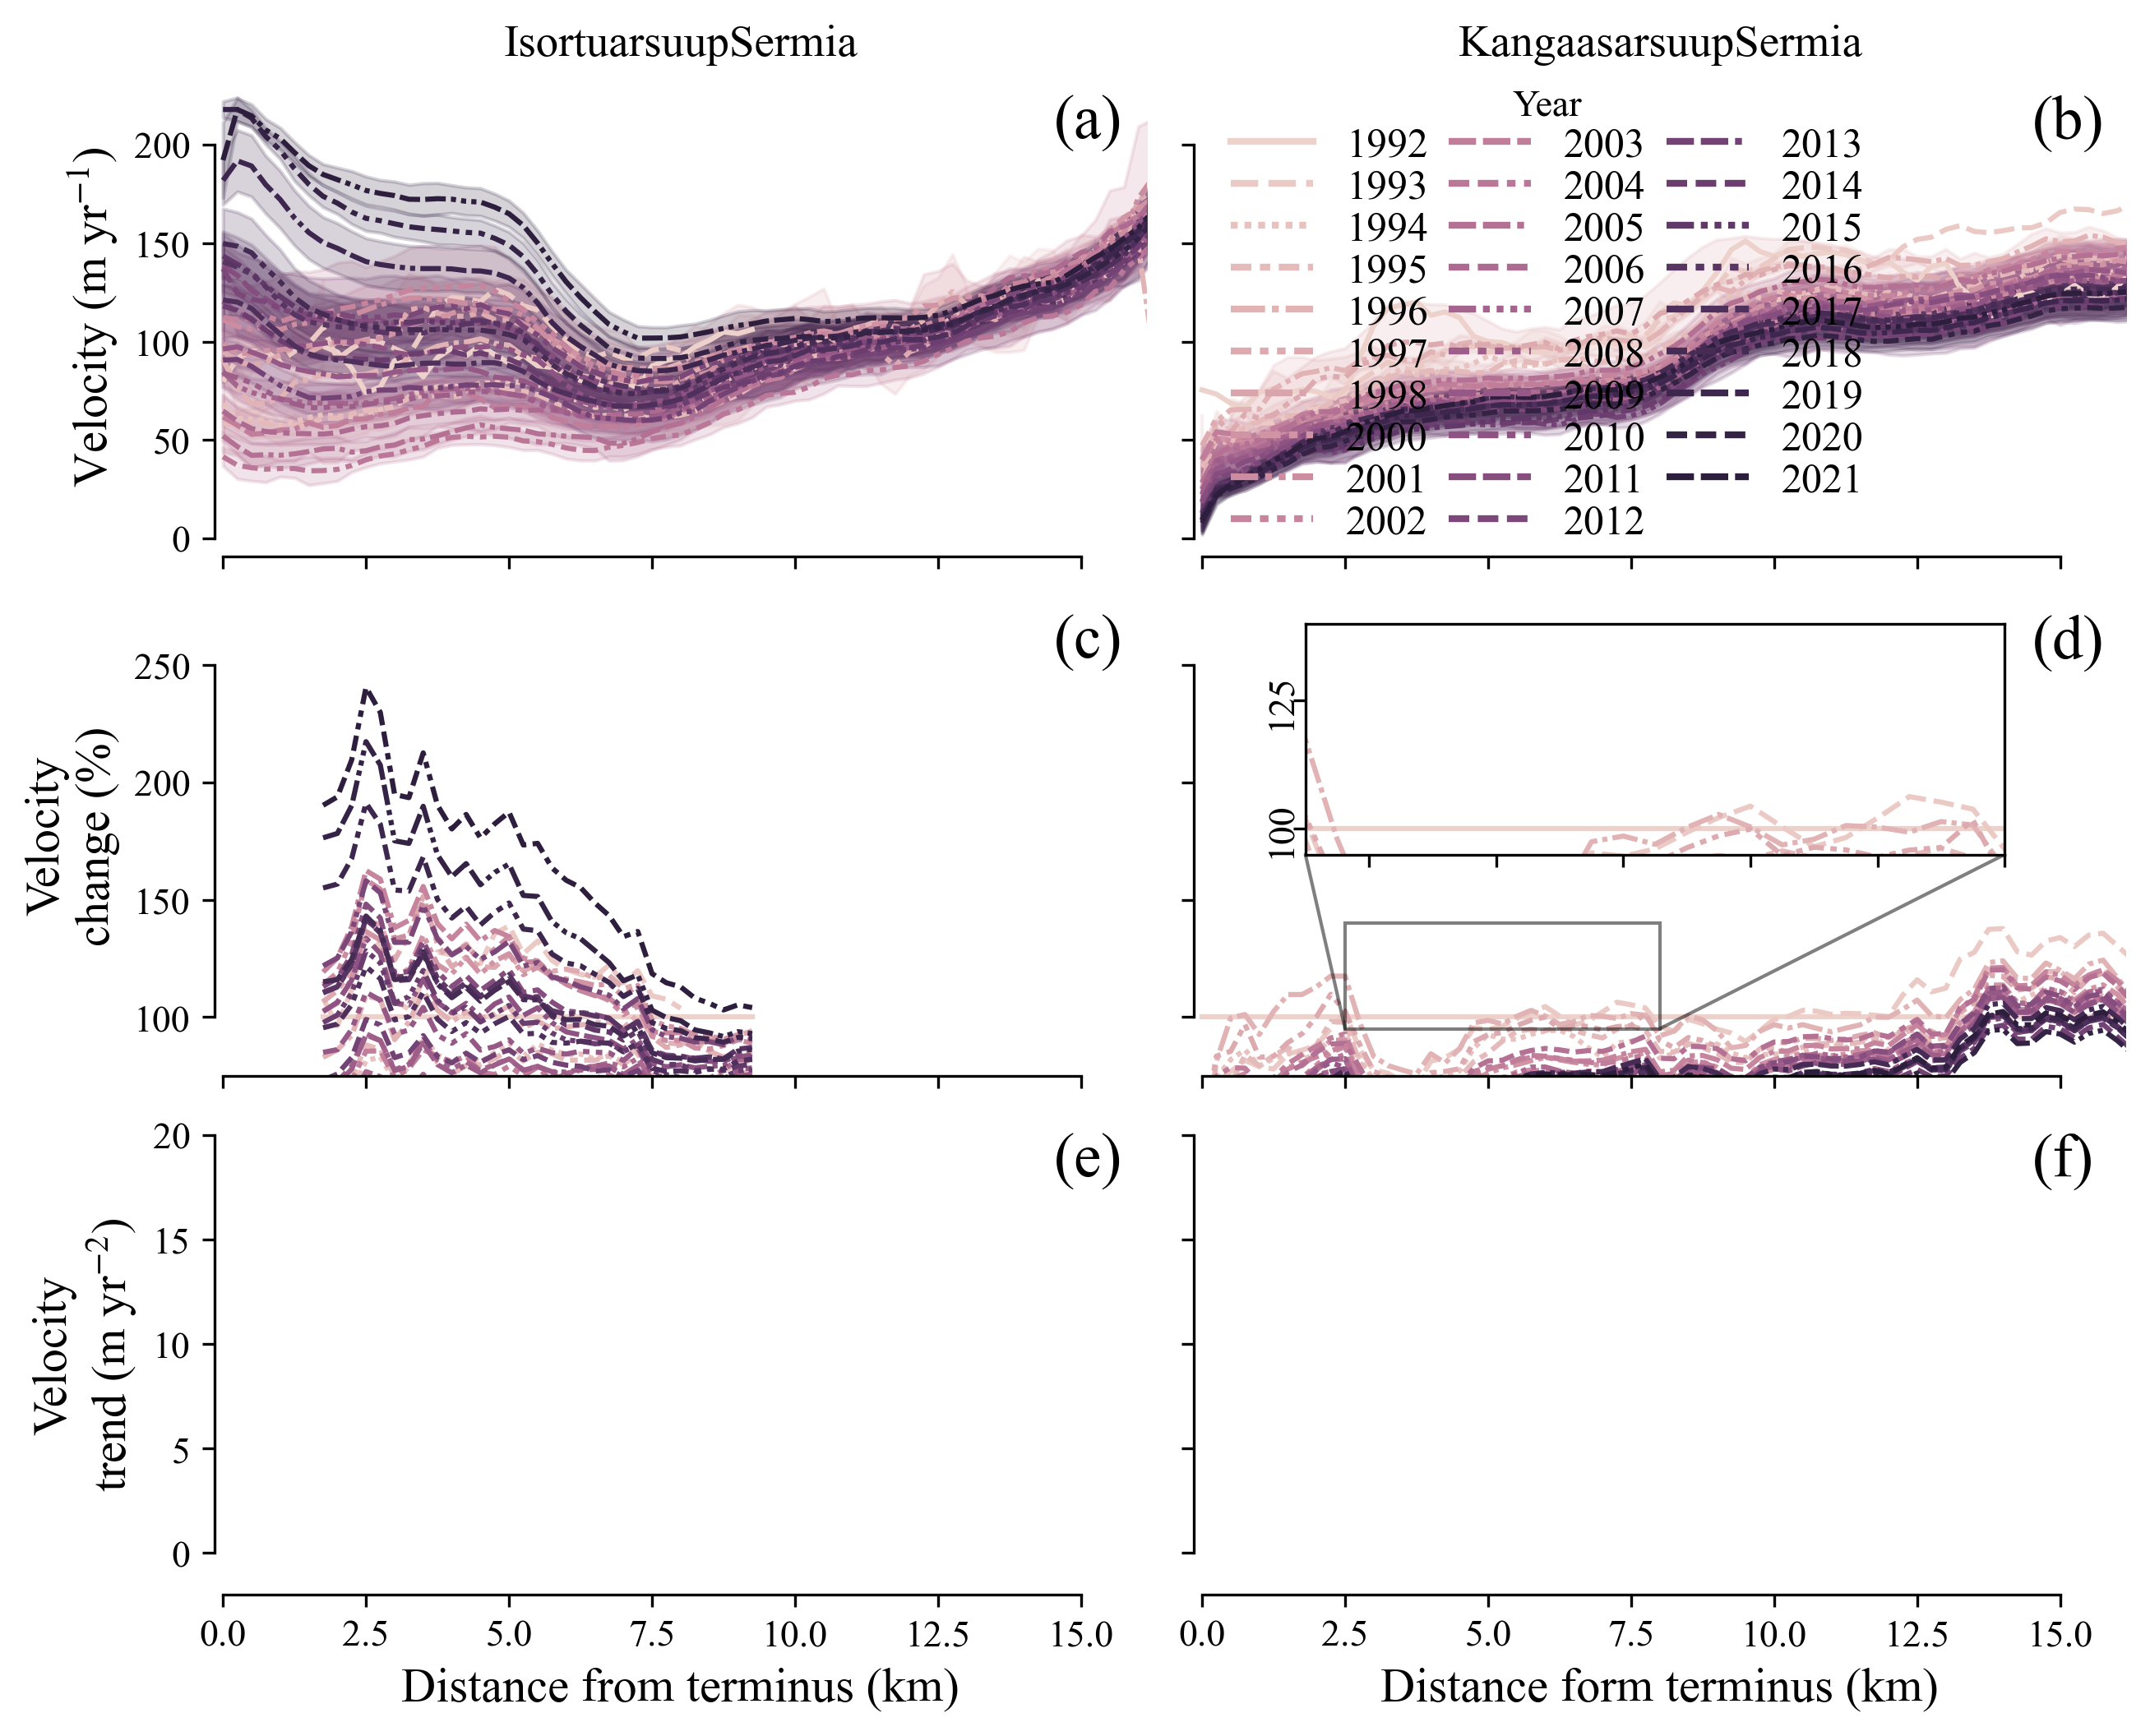

In [14]:
# annual velocities, percentage, and trends
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 8), sharex=True, sharey="row")

for i, g in enumerate(selection):
    # annual velocity with standard deviation as measure of spread
    idx = (v_all["glacier"] == g) & (v_all["year"] < 2022)
    if i == 1:
        lgnd = "full"
    else:
        lgnd = False
    sns.lineplot(
        data=v_all.loc[idx, :],
        x="cd_km",
        y="v",
        errorbar="sd",  # with standard deviation as measure of spread
        hue="year",
        style="year",
        ax=axs[0, i],
        legend=lgnd,
    )
    axs[1, i].set_ylim(top=251)
    axs[0, i].set_title(g)

    # percentage change
    idx = (v_annual["glacier"] == g) & (v_annual["year"] < 2022)
    sns.lineplot(
        data=v_annual.loc[idx],
        x="cd_km",
        y="pcnt",
        hue="year",
        style="year",
        ax=axs[1, i],
        legend=False,
    )
    axs[1, i].set_ylim(75, 280)

    # acceleration - significant only
    idx = (annual_trend["glacier"] == g) & (annual_trend["pvalue"] <= 0.05)
    axs[2, i].errorbar(
        x=annual_trend.loc[idx, "cd_km"],
        y=annual_trend.loc[idx, "slope"],
        yerr=annual_trend.loc[idx, "stderr"],
        ecolor="grey",
        fmt=".",
        color="k",
    )
    axs[2, i].set_ylim(-2, 21)

# label axes
labs = "abcdefghi"
for i, ax in enumerate(axs.flat):
    ax.set_xlim(-0.150, 16.150)
    ax.annotate(f"({labs[i]})", xy=(0.9, 0.87), xycoords="axes fraction", fontsize=18)
    sns.despine(ax=ax, trim=True)

###### add inset to KS % velocity plot
axins = axs[1, 1].inset_axes([0.12, 0.46, 0.75, 0.48])
idx = (v_annual["glacier"] == "KangaasarsuupSermia") & (v_annual["year"] < 2022)
sns.lineplot(
    data=v_annual.loc[idx],
    x="cd_km",
    y="pcnt",
    hue="year",
    style="year",
    ax=axins,
    legend=False,
)

# sub region of the original image
x1, x2, y1, y2 = 2.5, 8, 95, 140
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticks(axins.get_yticks()[1:3])
axins.set_ylabel(None)
axins.set_xlabel(None)
axins.set_yticklabels(
    [int(q) for q in axins.get_yticks()], rotation=90, ha="center", va="center"
)
axs[1, 1].indicate_inset_zoom(axins, edgecolor="black")

# label axes
axs[0, 0].set_ylabel("Velocity (m yr$^{-1}$)")
axs[1, 0].set_ylabel("Velocity\nchange (%)")
axs[2, 0].set_ylabel("Velocity\ntrend (m yr$^{-2}$)")
axs[2, 0].set_xlabel("Distance from terminus (km)")
axs[2, 1].set_xlabel("Distance form terminus (km)")

# tidy up legend
sns.move_legend(
    axs[0, 1],
    loc="upper left",
    bbox_to_anchor=(0, 1.05),
    ncol=3,
    fontsize=12,
    title="Year",
    labelspacing=0.1,
    columnspacing=0.5,
    frameon=False,
)

leg = axs[0, 1].get_legend()
for legobj in leg.legend_handles:
    legobj.set_linewidth(2)
plt.subplots_adjust(hspace=0.08, wspace=0.05)

# fig.savefig("../figures/f02.png", bbox_inches="tight")

print(
    "Figure 2: Annual average ice velocity (2013–2021) profiles along centrelines shown in Figure 1 at\n\
    (a) Isortuarsuup Sermia, and (b) Kangaasarsuup Sermia. (c) and (d) show percentage change relative to 2013. \n\
        (e) and (f) show linear trends where regression slope coefficients are significant at p ≤ .05; \n\
            error bars denote standard error of the estimate."
)

## Time series

In [23]:
# EXPECTED RUNTIME: ~40 seconds


start_d = pd.to_datetime("2016-01-01")


stop_d = pd.to_datetime("2022-01-01")


# distances = np.arange(500,10500,500)


distances = [1000, 10000]


date_dt_max = "30D"



# Get time series at each point/glacier


v_time_series = get_time_series(datasets, start_d, stop_d, distances, date_dt_max)


v_time_series["day_sep"] = v_time_series["date_dt"] / pd.Timedelta("1D")

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3169: UserWarning: Sending large graph of size 2.38 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
                         Debugging information
                         ---------------------
                         old task state: released
                         old run_spec: (<function execute_task at 0x0000025421B17F60>, (ImplicitToExplicitIndexingAdapter(array=LazilyVectorizedIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x0000025425D46840>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x000002547F0A9260>, encoded_fill_values={-32767}, decoded_fill_value=nan, dtype=dtype('float32')), dtype=dtype('float32')), key=VectorizedIndexer((array([[[[ 3050,  3050,  3050, ...

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

Figure 3: Time series of ice surface velocity at (a) 1 km and (b) 10 km from the terminus at
      the lake-terminating Isortuarsuup Sermia (blue) and
            the land-terminating Kangaasarsuup Sermia (orange, dashed). 
      These velocities are computed from image-pairs separated by ≤ 30 days.
            Lines show the rolling 28 day median.


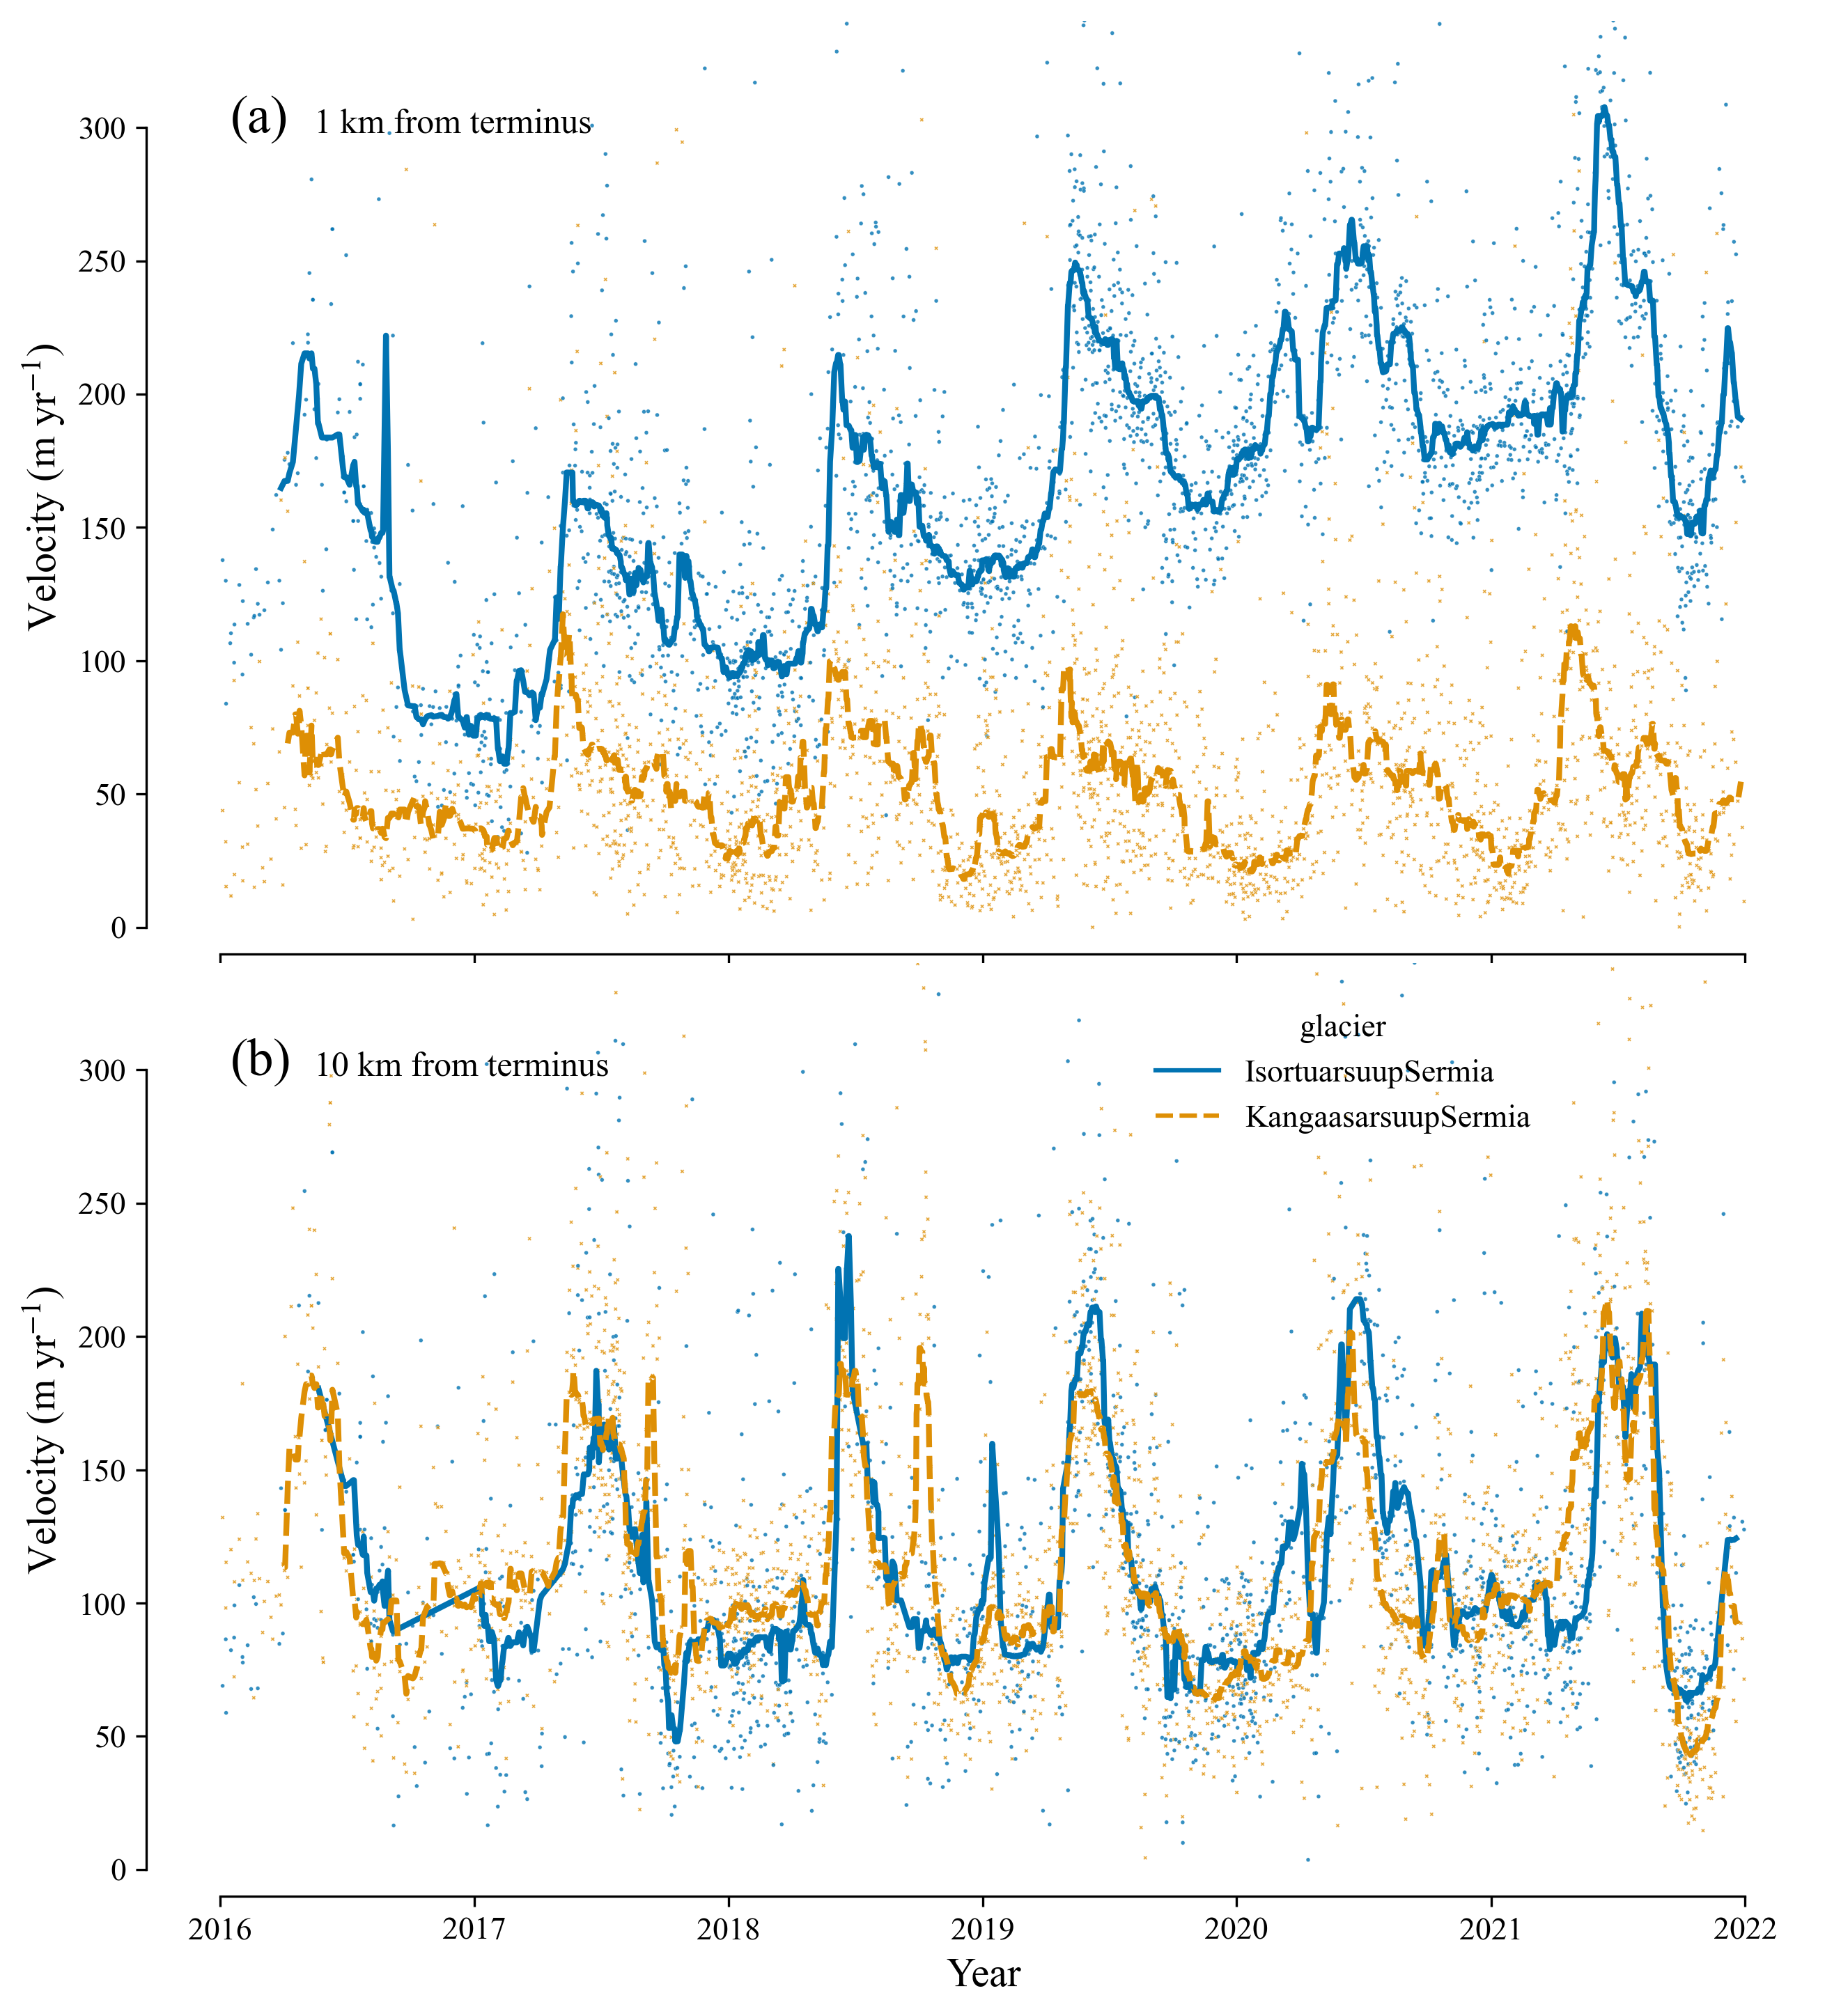

INFO:distributed.core:Event loop was unresponsive in Nanny for 3511.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3512.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3512.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3512.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3512.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This ca

In [25]:
### plotting with simple median filter
fg = sns.relplot(
    data=(
        v_time_series.set_index("mid_date")
        .groupby(["glacier", "cd"])["v"]
        .rolling("28D", min_periods=10, center=True)
        .median()
        .rename("smoothed_v")
        .reset_index()
    ),
    x="mid_date",
    y="smoothed_v",
    hue="glacier",
    palette="colorblind",
    style="glacier",
    linewidth=2,
    row="cd",
    kind="line",
    aspect=1.8,
)

for d in distances:
    tsdf_idx = v_time_series["cd"] == d
    sns.scatterplot(
        data=v_time_series.loc[tsdf_idx],
        x="mid_date",
        y="v",
        hue="glacier",
        palette="colorblind",
        style="glacier",
        alpha=0.8,
        s=2,
        ax=fg.axes_dict[d],
        legend=False,
    )

sns.move_legend(fg, loc="upper right", bbox_to_anchor=(0.7, 0.5))  # (0.75, 0.53)

fg.set_titles("")

labs = "abcdefg"
for i, ax in enumerate(fg.axes.flatten()):
    ax.annotate(f"({labs[i]})", xy=(0.05, 0.88), xycoords="axes fraction", fontsize=18)
    ax.annotate(
        f"{str(int(distances[i]/1000))} km from terminus",
        xy=(0.1, 0.88),
        xycoords="axes fraction",
        fontsize=12,
    )
    # ax.set_title(f'Distance from terminus: {str(int(distances[i]/1000))} km', y=0.82, loc='left')

fg.set(ylim=(-10, 340))
fg.set_xticklabels([2016, 2017, 2018, 2019, 2020, 2021, 2022])
fg.set(ylabel=("Velocity (m yr$^{-1}$)"), xlabel=("Year"))
fg.despine(trim=True)

plt.subplots_adjust(hspace=0.01)

# fg.fig.savefig('../figures/f03.png',
#                bbox_inches='tight')

print(
    "Figure 3: Time series of ice surface velocity at (a) 1 km and (b) 10 km from the terminus at\n\
      the lake-terminating Isortuarsuup Sermia (blue) and\n\
            the land-terminating Kangaasarsuup Sermia (orange, dashed). \n\
      These velocities are computed from image-pairs separated by ≤ 30 days.\n\
            Lines show the rolling 28 day median."
)

## Seasonal averages

In [19]:
# EXPECTED RUNTIME: ~2 minutes


start_d = pd.to_datetime("2016-01-01")


stop_d = pd.to_datetime("2022-01-01")


date_dt_max = "30D"


resample_frequency = "Q-FEB"



v_seasonal = get_seasonal_averages(datasets, start_d, stop_d, date_dt_max, resample_frequency)

seasonal_trend = (

    v_seasonal.groupby(["glacier", "season", "cd"])
    .apply(lambda q: pd.Series(linregress(x=q["year"], y=q["v"])))
    .reset_index()
    .rename(columns={0: "slope", 1: "intercept", 2: "rvalue", 3: "pvalue", 4: "stderr"})
)



seasonal_trend["significant\np<0.05"] = seasonal_trend["pvalue"] <= 0.05


seasonal_trend["Distance (km)"] = seasonal_trend["cd"] / 1000

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3169: UserWarning: Sending large graph of size 1.20 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

Figure 4: Seasonal velocity trends (2016–2021) along glacier centrelines at (A) Isortuarsuup Sermia and (B) Kangaasarsuup Sermia for
    winter (DJF, purple circles), spring (MAM, gold diamonds), summer (JJA, orange triangles) and
        autumn (SON, grey crosses). Seasonal trends derived from velocity fields were “date_dt” ≤ 30 days. 
            Trends shown are linear fits. Significant (p ≤ .05) trends shown by larger symbols, otherwise smaller symbols;
                error bars denote standard error of the estimate.


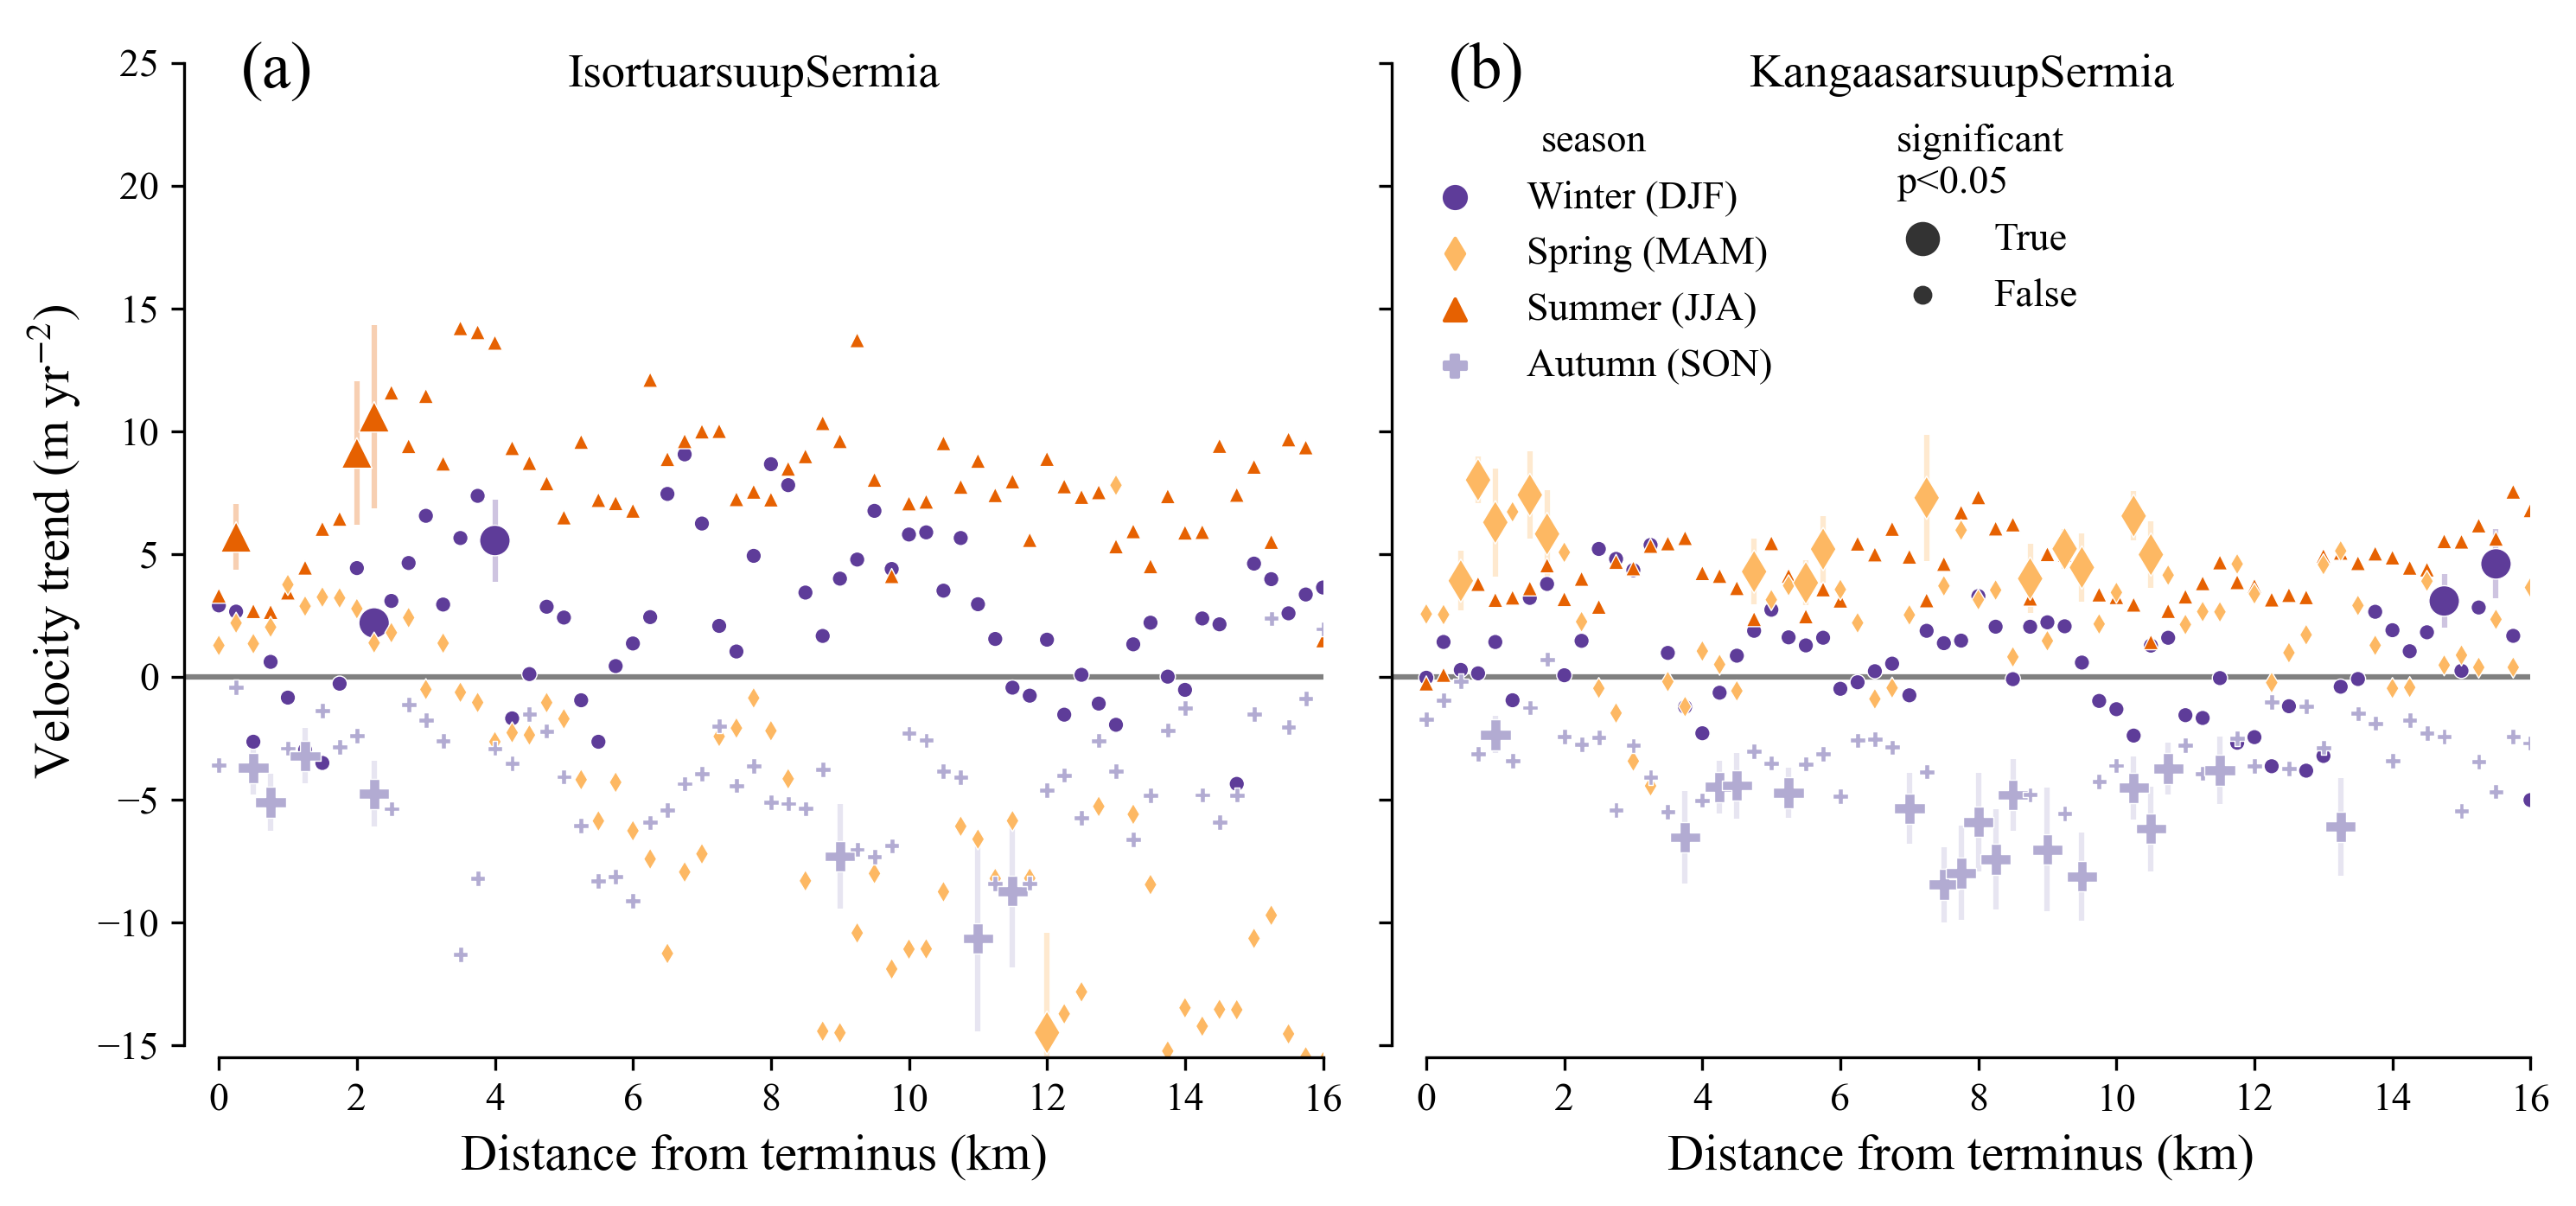

In [21]:
# color palette. from PuOr from colorbrewer. should be BW and colorblind safe
rgbs = [(94, 60, 153), (253, 184, 99), (230, 97, 1), (178, 171, 210)]
rgbs = [tuple(i / 255 for i in a) for a in rgbs]
season_colors = dict(zip(["DJF", "MAM", "JJA", "SON"], rgbs))

## plot seasonal trends - color and style by season. size by significance
fg = sns.relplot(
    data=seasonal_trend,
    x="Distance (km)",
    y="slope",
    hue="season",
    hue_order=["DJF", "MAM", "JJA", "SON"],
    palette=rgbs,
    style="season",
    style_order=["DJF", "MAM", "JJA", "SON"],
    markers=["o", "d", "^", "P"],
    size="significant\np<0.05",
    size_order=[True, False],
    col="glacier",
    legend=False,
)

fg.map(plt.axhline, y=0, color="grey", zorder=0.5)
fg.set(xlim=(-0.5, 16), ylim=(-15.5, 26.5), yticks=np.arange(-15, 30, 5))
fg.set_ylabels("Velocity trend (m yr$^{-2}$)")
fg.despine(trim=True)

# label axes
labs = "abcdef"
for i, ax in enumerate(fg.axes.flat):
    ax.annotate(f"({labs[i]})", xy=(0.05, 0.94), xycoords="axes fraction", fontsize=18)
    t = ax.get_title()
    ax.set_title(t.split("glacier = ")[1], y=0.92)
    ax.set_xlabel("Distance from terminus (km)")

# error bars
for g in selection:
    for S in ["DJF", "MAM", "JJA", "SON"]:
        idx = (
            (seasonal_trend["glacier"] == g)
            & (seasonal_trend["season"] == S)
            & (seasonal_trend["significant\np<0.05"] == True)
        )
        fg.axes_dict[g].errorbar(
            x=seasonal_trend.loc[idx, "Distance (km)"],
            y=seasonal_trend.loc[idx, "slope"],
            yerr=seasonal_trend.loc[idx, "stderr"],
            fmt="None",
            zorder=0.5,
            alpha=0.3,
            ecolor=season_colors[S],
        )

# ridiculous routine. make and plot some dummy data in order to construct two separate legends
# because just using the `ncols` paramter splits the seasons over two columns, which is ugly
dummy = pd.DataFrame(
    {
        "a": [-5, -5, -5, -5],
        "b": [0, 0, 0, 0],
        "season": ["Winter (DJF)", "Spring (MAM)", "Summer (JJA)", "Autumn (SON)"],
    }
)
q = sns.scatterplot(
    data=dummy,
    x="a",
    y="b",
    hue="season",
    hue_order=["Winter (DJF)", "Spring (MAM)", "Summer (JJA)", "Autumn (SON)"],
    palette=rgbs,
    style="season",
    style_order=["Winter (DJF)", "Spring (MAM)", "Summer (JJA)", "Autumn (SON)"],
    markers=["o", "d", "^", "P"],
    ax=fg.axes[0][0],
    legend=True,
)
sns.move_legend(q, loc="upper left", bbox_to_anchor=(1.05, 0.94), frameon=False)

dummy = pd.DataFrame({"a": [-5, -5], "b": [0, 0], "significant\np<0.05": [True, False]})
r = sns.scatterplot(
    data=dummy,
    x="a",
    y="b",  # palette=[rgbs[0],rbgs[2]],
    size="significant\np<0.05",
    size_order=[True, False],
    ax=fg.axes[0][1],
)

sns.move_legend(r, loc="upper left", bbox_to_anchor=(0.4, 0.94), frameon=False)
fg.axes[0][0].set_zorder(2)

# fg.fig.savefig('../figures/f04.png', bbox_inches='tight')

print(
    "Figure 4: Seasonal velocity trends (2016–2021) along glacier centrelines at (A) Isortuarsuup Sermia and (B) Kangaasarsuup Sermia for\n\
    winter (DJF, purple circles), spring (MAM, gold diamonds), summer (JJA, orange triangles) and\n\
        autumn (SON, grey crosses). Seasonal trends derived from velocity fields were “date_dt” ≤ 30 days. \n\
            Trends shown are linear fits. Significant (p ≤ .05) trends shown by larger symbols, otherwise smaller symbols;\n\
                error bars denote standard error of the estimate."
)